# Keras

Wir verwenden die folgenden Plattformen, um unsere AI Exploration weiterzuführen:

* Keras: eine AI-Plattform, die auf die das TensorFlow-Backend von Google aufsetzt.
* OpenAI Gym: eine Sammlung von Problemen (z.B. Games), die über eine einheitliche Schnittstelle gelöst bzw. trainiert werden können.

Bevor wir uns wieder dem Reinforcement Learning zuwenden, lernen wir die obigen Werkzeuge kennen, indem wir ein bekanntes Problem lösen: die Erkennung der MNIST-Digits.

Zuerst importieren wir die nötigen Bibliotheken:

In [34]:
#%conda install numpy tensorflow matplotlib

# Imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img


## Das MNIST-Dataset
Das MNIST-Dataset ist bereits als Beispiel verfügbar.

In [35]:
mnist_digits = keras.datasets.mnist.load_data()

Wir bereiten das Modell vor und teilen das Dataset in vier Teile:
* Train vs. Test
  * Train: verwenden wir, um eine AI zu trainieren
  * Test: verwenden wir, um die Qualität der AI zu messen (die Test-Daten dürfen nicht fürs Training verwendet werden, sonst könnte die AI die Daten auswendig lernen (overfitting)).
* `x` vs. `y`
  * `x` bezeichnet üblicherweise die Quelldaten, im Beispiel die Bilder (Pixel).
  * `y` bezeichnet üblicherweise die Labels (also die wahren Werte)

In [36]:
# Split the data between train and test sets
(x_train, y_train), (x_test, y_test) = mnist_digits

Wir schauen uns an, wie die Daten aussehen:

Shape of training data (x_train[0]): (28, 28)
Content of labels (y_train[0]): 5


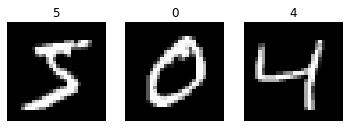

In [37]:
print(f"Shape of training data (x_train[0]): {x_train[0].shape}")
print(f"Content of labels (y_train[0]): {y_train[0]}")

fig, axs = pyplot.subplots(ncols=3)
# Lets print a few samples:
for i in range(3):
    # Plot raw pixel data aus x_train
    axs[i].imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
    axs[i].set_title(y_train[i])
    axs[i].set_axis_off()

Die Daten müssen noch etwas massiert werden, um die richtige Form ("shape") zu haben.

In [38]:
# Model / data parameters
num_classes = 10  # Number of unique digits
input_shape = (28, 28)  # 28x28 pixels

# Scale [1, 255] pixels to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# Convert class vectors to binary class matrices (one-hot encoding)
print(f"Labels before one-hot categorical conversion: shape: {y_train.shape}, example: {y_train[0]}")
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(f"Labels after one-hot categorical conversion: shape: {y_train.shape}, example: {y_train[0]}")

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples
Labels before one-hot categorical conversion: shape: (60000,), example: 5
Labels after one-hot categorical conversion: shape: (60000, 10), example: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## Build the Model

Nun können wir das neuronale Netzwerk definieren. Wir wählen ein ganz simples Netzwerk: 
* ein Input-Layer, der _flachgedrückt_ (flattened) wird, d.h. aus 28x28 Pixel werden 784x1 Zahlen.
* ein Output-Layer, der auf die zehn möglichen Ziffern (_categories_) schliesst. `Dense` bedeutet, dass der Layer _fully-connected_ ist, also dass jedes der 784 Input-Neuronen durch eine Synapse mit jedem Output-Neuron verbunden ist.
* als [Activation-Function](https://ml-cheatsheet.readthedocs.io/en/latest/nn_concepts.html#activation-functions) wählen wir [softmax](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#softmax)
  * softmax berechnet einen Vektor mit der Betragssumme 1 und kann so als Wahrscheinlichkeitsverteilung über die 10 Klassen angesehen werden.

In [39]:
model = keras.Sequential(
    [
       keras.Input(shape=input_shape),
       layers.Flatten(),
       layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_7 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


Die Anzahl Parameter ergibt sich aus der Anzahl Synapsen (Verbindungen: 784 * 10) plus der Anzahl _Biases_ (je einer pro Output-Neuron, also 1 * 10).

## Train the Model

Wir können das Modell bereits trainieren. Das Training teilt sich zweifach:
* _Batch_: Anzahl Samples (Trainings-Daten) die mit dem gleichen Modell evaluiert werden, bevor das Modell geändert wird.
  * Die Gradienten werden addiert.
  * Nach dem Batch wird das Modell anhand der akkumulierten Gradienten angepasst.
  * Je nach Optimizer werden alle (Batch Gradient Descent) oder nur ein paar wenige (Stochastic Gradient Descent) Samples des Batch für die Back Propagation verwendet.
* _Epoche_: Wie oft das ganze Dataset trainiert wird.
  * Ist `epochs=1` hat jedes Sample genau eine Chance, das Modell zu beinflussen.
  * Nach jeder Epoche wird validiert, wie gut das Modell bereits ist. Dazu wird ein Teil der Trainings-Daten evaluiert. `validation_split=0.1` besagt, dass 10% der Trainingsdaten für die Validierung zur Seite gestellt werden.
  * Bei einer `batch_size = 128` und `validation_split=0.1` gibt es `60000*(1-0.1)/128 = 422` Model Updates pro Epoche.

Man kann sich das als zwei verschachtelte for-Loops vorstellen: Der äussere Loop definiert die Epochen und teilt das Dataset in Batches auf. Der innere Loop evaluiert jeden Batch und akkumuliert dabei den Fehler. Am Schluss jedes Batches wird das Modell angepasst mit Back Prop.

Wir müssen angeben
* Loss-Funktion - wir wählen `categorical_crossentropy` ([Details hier](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy)).
* Optimizer - es gibt mittlerweile eine Vielzahl von Backprop-Algorithmen, die schneller konvergieren als SGD (_Stochastic Gradient Descent_), wir verwenden den populären [Adam]-Algorithmus.

In [40]:
batch_size = 128
epochs = 5

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
422/422 [==============================] - 2s 3ms/step - loss: 0.7040 - accuracy: 0.8287 - val_loss: 0.3507 - val_accuracy: 0.9133
Epoch 2/5
422/422 [==============================] - 1s 2ms/step - loss: 0.3775 - accuracy: 0.8988 - val_loss: 0.2863 - val_accuracy: 0.9273
Epoch 3/5
422/422 [==============================] - 1s 2ms/step - loss: 0.3312 - accuracy: 0.9092 - val_loss: 0.2621 - val_accuracy: 0.9295
Epoch 4/5
422/422 [==============================] - 1s 2ms/step - loss: 0.3102 - accuracy: 0.9138 - val_loss: 0.2499 - val_accuracy: 0.9312
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 0.2969 - accuracy: 0.9176 - val_loss: 0.2432 - val_accuracy: 0.9347


## Evaluation
Wenn die Train-Accuracy gut genug ist, evaluieren wir das Modell anhand der zu Beginn zurückgestellten Test-Daten.

Die _Accuracy_ misst den Quotienten der richtigen Antworten, 0.92 entspricht also einer Fehlerquote von 8%.

313/313 [==============================] - 1s 3ms/step - loss: 0.2818 - accuracy: 0.9209
Test loss: 0.2818126380443573
Test accuracy: 0.9208999872207642


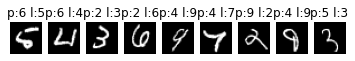

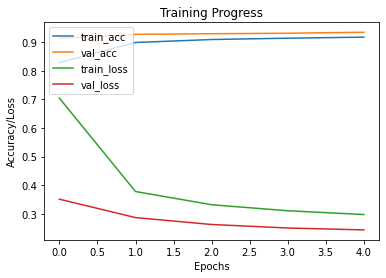

In [41]:
score = model.evaluate(x_test, y_test, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Look at false predictions
def show_error_exemplars(model, data, labels):
    predictions = model.predict(data[:1000], batch_size=128)
    max_predictions = np.argmax(predictions, axis=-1)
    max_labels = np.argmax(labels[:1000], axis=-1)

    delta = np.where(np.not_equal(max_predictions, max_labels))[0][:9]
    fig, axs = pyplot.subplots(ncols=9)
    for i, idx in enumerate(delta):
        # Plot raw pixel data aus x_train
        axs[i].imshow(x_test[idx], cmap=pyplot.get_cmap('gray'))
        axs[i].set_title(f"p:{max_predictions[idx]} l:{max_labels[idx]}")
        axs[i].set_axis_off()

def plot_hist(hist):
    pyplot.figure()
    pyplot.plot(hist.history["accuracy"])
    pyplot.plot(hist.history["val_accuracy"])
    pyplot.plot(hist.history["loss"])
    pyplot.plot(hist.history["val_loss"])
    pyplot.title("Training Progress")
    pyplot.ylabel("Accuracy/Loss")
    pyplot.xlabel("Epochs")
    pyplot.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    pyplot.show()


show_error_exemplars(model, x_test, y_test)
plot_hist(history)


### Fragen
1. Wie werden die verfügbaren Daten aufgeteilt?
  * in welche Teile mit welcher Funktion?
  * wozu?
2. Was ist das One-Hot-Encoding?
3. Was ist der Unterschied von Batch und Epoche?
4. Was misst die Accuracy eigentlich?

### Aufgaben
1. Spiele mit den _Metaparametern_: was passiert mit der Trainingszeit und der Accuracy wenn du `batch_size` auf `1` setzt? Weshalb?
2. Probiere andere _Optimizer_ aus, zum Beispiel `"SGD"`.
3. Weshalb ist die Accuracy in der Evaluation oft schlechter als während des Trainings rapportiert?

### Moar Layers

Das bestehende Modell ist ja sehr einfach - es hat gar keine hidden Layers.
* Können wir besser werden, wenn wir einen (oder 4) zusätzlichen hidden Layer einfügen?
* Was passiert mit der Modellgrösse (Anzahl lernbarer Parameter)? Der Trainingszeit?

In [42]:
model2 = keras.Sequential(
    [
       keras.Input(shape=input_shape),
       layers.Flatten(),
       layers.Dense(512, activation="elu"),
       layers.Dense(512, activation="elu"),
       layers.Dense(512, activation="elu"),
       layers.Dense(512, activation="elu"),
       layers.Dense(num_classes, activation="softmax"),
    ]
)

model2.summary()

model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history2 = model2.fit(x_train, y_train, batch_size=128, epochs=5, validation_split=0.1)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 512)               401920    
                                                                 
 dense_9 (Dense)             (None, 512)               262656    
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dense_11 (Dense)            (None, 512)               262656    
                                                                 
 dense_12 (Dense)            (None, 10)                5130      
                                                                 
Total params: 1,195,018
Trainable params: 1,195,018
No

313/313 [==============================] - 5s 16ms/step - loss: 0.0978 - accuracy: 0.9728
Test loss: 0.09783564507961273
Test accuracy: 0.9728000164031982


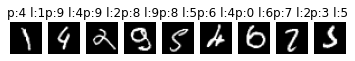

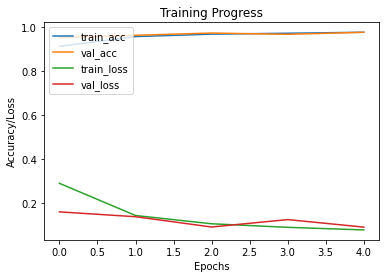

In [43]:
score = model2.evaluate(x_test, y_test, verbose=1)

print("Test loss:", score[0])
print("Test accuracy:", score[1])

show_error_exemplars(model2, x_test, y_test)
plot_hist(history2)

### Kein Overfitting?
Eigentlich wäre zu erwarten, dass ein Netzwerk mit über 1e6 Parametern und 6e4 Samples zu massivem Overfitting neigte: das Modell würde dann die Samples auswendig lernen, aber im Evaluations-Durchgang viel schlechter abschneiden, weil es nicht mehr gut generalisiert.

Interessanterweise scheint das Netzwerk keine Anzeichen für massives Overfitting zu zeigen.

[Hier gibt es ein paar Gedanken](https://datascience.stackexchange.com/questions/19874/why-doesnt-overfitting-devastate-neural-networks-for-mnist-classification) dazu, weshalb das nicht passiert.

## Convolutional Neural Networks

Wie können wir unser simples Modell verbessern? Zusätzliche hidden Layers haben nicht den gewünschten Effekt gebracht, aber die Trainingskosten dramatisch vergrössert.

Seit dem Erfolg von [AlexNet (2012)](https://en.wikipedia.org/wiki/AlexNet) ist das Standard-Verfahren dazu die Einführung von convolutional Layers, womit unser Modell ein Convolutional Neural Network (CNN) wird.

Wir beschäftigen uns hier nur ganz kurz mit den grundlegenden Ideen von CNNs - wer mehr dazu wissen möchte, liest bei [Wikipedia](https://en.wikipedia.org/wiki/Convolutional_neural_network) oder im [Deep Learning Book](https://www.deeplearningbook.org/contents/convnets.html).

CNNs werden durch zwei Beobachtungen inspiriert:

### Struktur von Bilddaten

Beim Einsatz eines dense Layers kann jedes Pixel gleichberechtigt mit jedem anderen Pixel die Wahrnehmung beeinflussen. Die Nachbarschaft von zwei Pixel oder die zweidimensionale Struktur des Bildes spielen dabei überhaupt keine Rolle - und tatsächlich haben wir ja oben die Information über die Zweidimensionalität aufgegeben und die Pixels geflatted.

Intuitiv scheint aber klar, dass die Nachbarschaft von Pixeln für die Interpretation des Bildes wichtig ist: Primitive Eigenschaften wie Kanten, aber auch höhere Eigenschaften ("enthält ein Bereich des Bildes ein Auge, eine Nase?") entstehen erst durch die Kombination von mehreren Pixeln auf einem begrenzten Raum. Wir möchten also ein Modell schaffen, das die Nachbarschaft berücksichtigt.

In einer anderen Sichtweise sind die Verbindungen zwischen weit entfernten Pixeln überflüssig, und unser Modell enthält also viel zu viele freie Parameter, die unnötige Trainingszeit und Speicher benötigen.

Eine weitere Beobachtung ist, dass insbesondere primitive Eigenschaften überall im Bild ähnlich aussehen. Beispielsweise können wir eine vertikale Kante detektieren indem wir die Differenz zwischen zwei horizontal benachbarten Pixel berechnen. Diese Differenzberechnung wird aber überall im Bild gleich funktionieren (beispielsweise als Multiplikation mit [-1, 1]). Wir möchten also die gleichen Parameter (Gewichte) für das ganze Bild verwenden (_parameter sharing_).

### Visuelle Verarbeitung im Gehirn
Versuche mit Katzen haben bereits in den 1960er Jahren gezeigt, dass der visuelle Cortex die Bilddaten des Sehnervs räumlich verarbeitet: Die Signale durchlaufen den Cortex in derselben 2D-Struktur, wie sie von der Netzhaut detektiert wurden. Die Schichten des Cortex detektieren mit zunehmender Laufzeit immer höherwertige Eigenschaften des Bildes, also zuerst horizontale und vertikale Kanten, später geometrische Muster, Bildteile wie "Auge", "Nase", und schliesslich werden ganze Konzepte wie "Barack Obama" erkannt. Die ersten Neuronen in den ersten Schichten verarbeiten für die Mustererkennung jeweils nur ein kleines, räumlich begrenztes "receptive Field".

### Umsetzung
Ein Conv-Layer besteht aus einer *Kernel*-Matrix, beispielsweise 3x3 Pixeln. Dieser Kernel wird über alle möglichen Positionen des Inputs geschoben und mit dem aktuellen Ausschnitt multipliziert. Für jeden Ausschnitt wird dabei ein Wert in den Output des Layers geschrieben. 

Haben wir also einen Kernel, der Kanten detektiert, wird der Output ein Bild ähnlich wie dieses Produzieren:

<table>
  <tr>
  <td>
    <figure>
      <img src="https://upload.wikimedia.org/wikipedia/commons/5/50/Vd-Orig.png" alt="Original"/>
    </figure>
  </td>
  <td>
    <figure>
      <img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/1445b36fef5ec4ca0e0b5d7e200c90afaf6af58b" />
    </figure>
  </td>
  <td>
    <figure>
      <img src="https://upload.wikimedia.org/wikipedia/commons/2/20/Vd-Rige1.png" alt="Ridge-Detection"/>
    </figure>
  </td>
  </tr>
  <tr>
  <td>
      <figcaption>Original-Bild</figcaption>
  </td>
  <td>
      <figcaption>Kernel-Matrix</figcaption>
  </td>
  <td>
      <figcaption>Kanten-Features (grau: keine Kante)</figcaption>
  </td>
  </tr>
</table>

[Quelle / Mehr bei Wikipedia](https://en.wikipedia.org/wiki/Kernel_(image_processing))

#### Parameter Sharing
Weil die Kantendetektion überall im Bild gleich läuft, werden die Gewichte für die Kernel-Matrix geteilt. Wir lernen also nicht separate Gewichte für jeden Bildausschnitt, sondern nur 9 Gewichte (für den 3x3-Kernel), was die Komplexität und den Speicherbedarf des Modells massiv reduziert. 

Für den Feed-Forward spielt dies keine grosse Rolle, aber bei der Backpropagation werden die Kernel-Gewichte gemeinsam für alle Bildausschnitte gelernt.

Damit wird Rechenkapazität frei, und wir können stattdessen pro Conv-Layer nicht nur einen, sondern eine Vielzahl (im Beispiel unten: 32) von Kernels trainieren, die unterschiedliche Konzepte in verschiedenen Ausrichtungen detektieren. Oft spricht man bei der Anzahl von Kernels von der Tiefe (_depth_) des Layers.

Je nachdem, wie mit die Ausschnitte am Rand des Bildes behandelt werden, führen Conv-Layers dazu, dass die Output-Grösse etwas kleiner wird als der Input. Bei unserem 3x3-Kernel wird der Output von 28x28 auf 26x26 Pixel gestutzt.

#### Pooling
Für die Bildwahrnehmung ist es oft egal, ob eine Eigenschaft (_Feature_) um ein paar wenige Pixel verschoben auftritt. Dies trifft auf primitive Features (Kanten...) genauso zu wie auf höhere Features ("Auge in der oberen Bildhälfte").

Dazu verwenden wir einen _Max-Pooling-Layer_, d.h. einen Layer ohne trainierbare Parameter der aus einem 2x2-Bereich des Inputs jeweils das Maximum auswählt. Dies führt dazu, dass tiefere Layer nur noch gröbere Informationen über die Positionen der detektierten Features erhalten; entsprechend wird beim Pooling die Output-Grösse halbiert.

<figure>
  <img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png" alt="Max-Pooling with a 2x2 window"/>
  <figcaption>Max-Pooling mit 2x2-Fenster</figcaption>
</figure>

#### Zusammenfassung
Das ganze CNN-Modell kann so visualisiert werden (Quelle: WP):

<figure>
  <img src="https://upload.wikimedia.org/wikipedia/commons/6/63/Typical_cnn.png?20151217030420" alt="CNN"/>
  <figcaption>CNN Struktur (Quelle: WP)</figcaption>
</figure>


### Let's Code a CNN

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_1 (RandomRo  (None, 28, 28, 1)        0         
 tation)                                                         
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                           

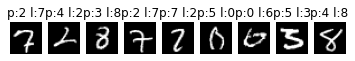

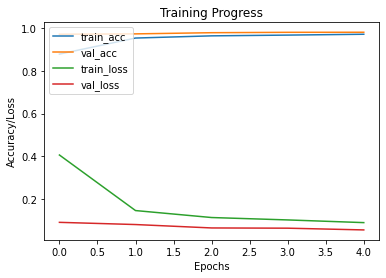

In [48]:
# Make sure images have shape (28, 28, 1)
# -> We append a singleton (depth=1) dimension at the end (-1), so that the dimensionality
#    is the same throughout the model (conv layers will create multiple kernels at each
#    "pixel" depending on their depth).
input_shape_1 = (28, 28, 1)
x_train_1 = np.expand_dims(x_train, -1)
x_test_1 = np.expand_dims(x_test, -1)
print("x_train shape:", x_train_1.shape)
print(x_train_1.shape[0], "train samples")
print(x_test_1.shape[0], "test samples")

model3 = keras.Sequential(
    [
        keras.Input(shape=input_shape_1),
        layers.RandomRotation( (-0.1, 0.1), fill_mode='reflect', interpolation='bilinear', seed=None, fill_value=0.0,),
        # First conv-layer: train 32 different 3x3 kernels.
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        # Max-pooling downsamples by a factor of 2.
        layers.MaxPooling2D(pool_size=(2, 2)),
        # Second conv-layer: train 64 detector kernels.
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        # And pool again, arriving at 64 5x5 feature maps.
        layers.MaxPooling2D(pool_size=(2, 2)),
        # Flatten into a single 5x5x64 = 1600 feature vector.
        layers.Flatten(),
        # Fully-connected (dense) output layer to the 10 digits.
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model3.summary()

model3.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history3 = model3.fit(x_train_1, y_train, batch_size=batch_size, epochs=5, validation_split=0.1)

score = model3.evaluate(x_test_1, y_test, verbose=1)
print("Test loss:", score[0]*100)
print("Test accuracy:", score[1]*100)

show_error_exemplars(model3, x_test_1, y_test)
plot_hist(history3)

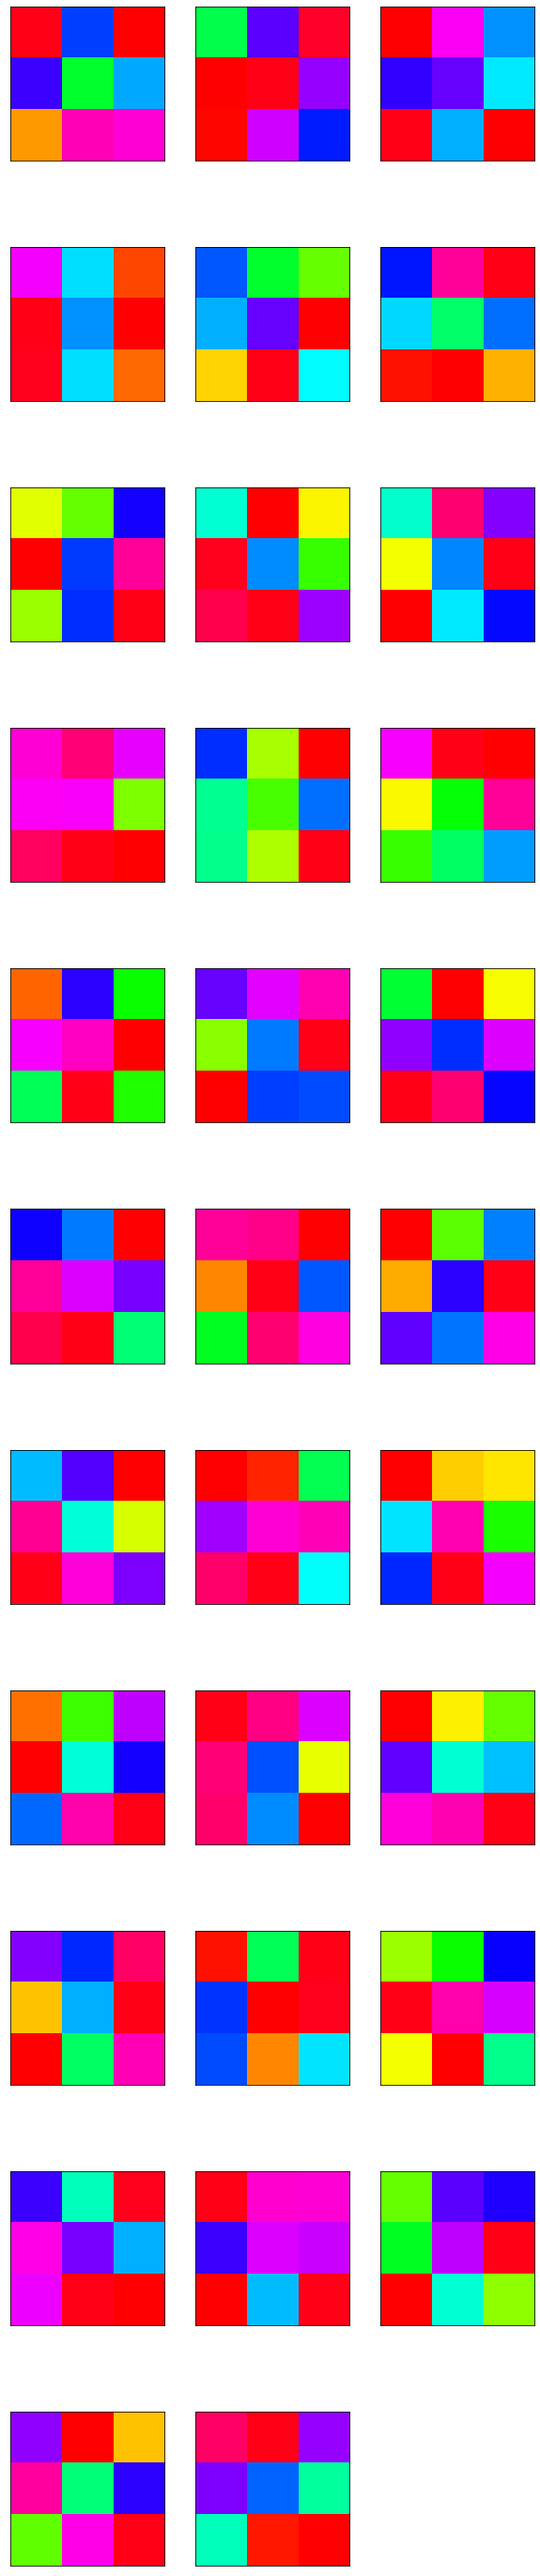

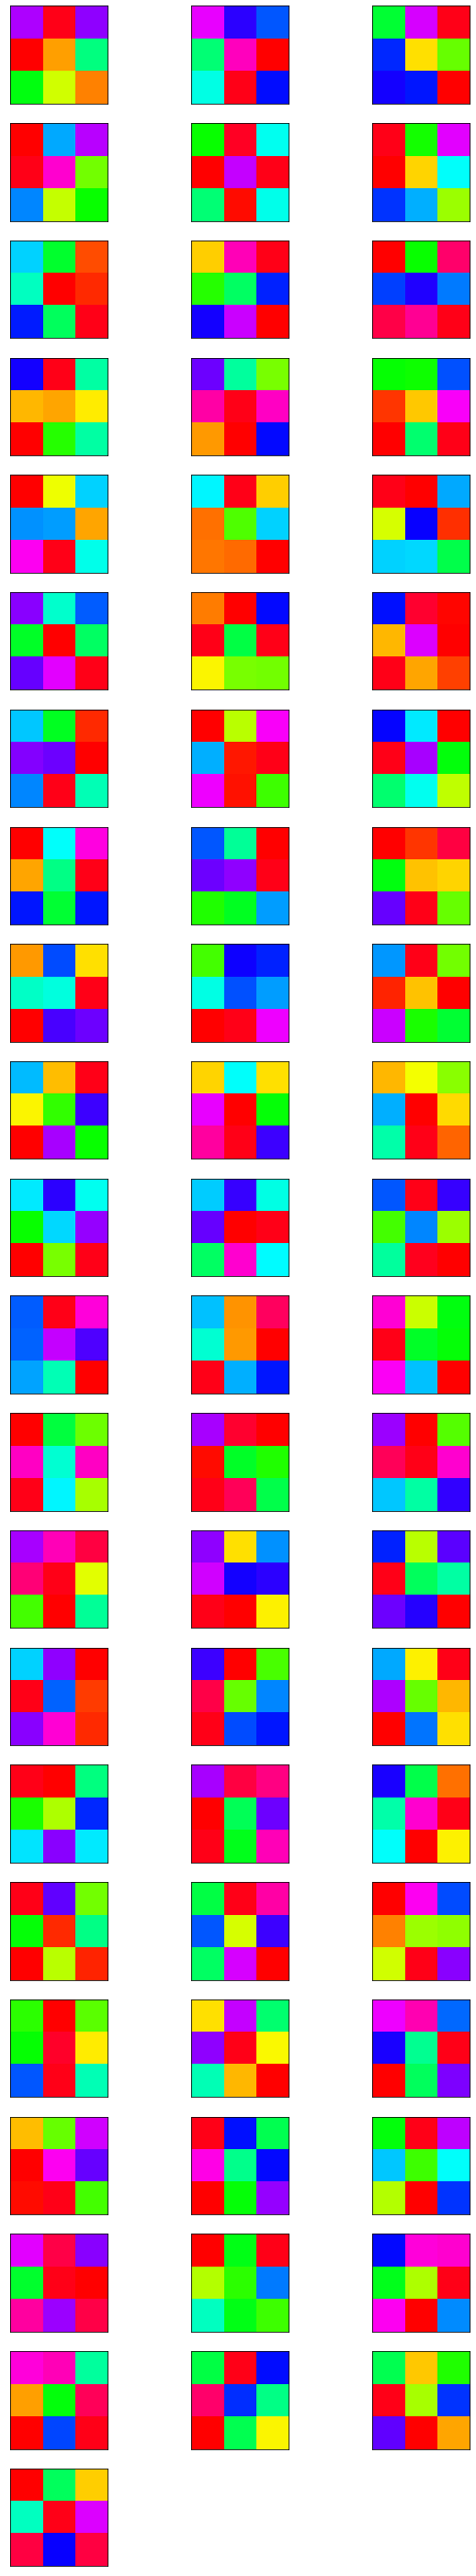

In [50]:
#Iterate thru all the layers of the model
for layer in model3.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min) 
        filter_cnt=1
        fig = pyplot.figure(figsize=(10, 150))
        #plotting all the filters
        for i in range(filters.shape[3]):
            #get the filters
            filt=filters[:,:,:, i]
            #plotting each of the channel, color image RGB channel
            ax= pyplot.subplot(filters.shape[3], filters.shape[0], filter_cnt )
            ax.set_xticks([])
            ax.set_yticks([])
            pyplot.imshow(filt[:,:, 0], cmap='hsv')
            filter_cnt+=1
        pyplot.show()

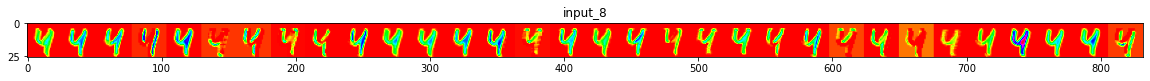

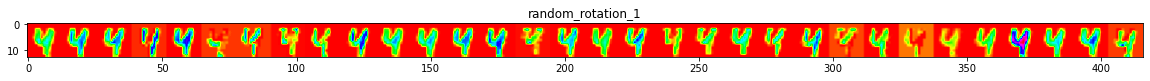

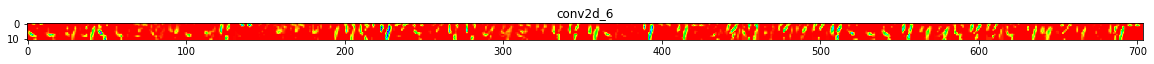

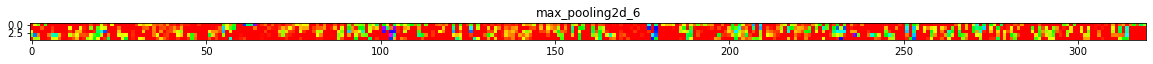

In [51]:
# Define a new Model, Input= image 
# Output= intermediate representations for all layers in the  
# previous model after the first.
successive_outputs = [layer.output for layer in model3.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = keras.models.Model(inputs = model3.input, outputs = successive_outputs)
#Load the input image
img = x_test_1[42]
img = np.expand_dims(img, axis=0)
# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(img)
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in visualization_model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
# Display the grid
    scale = 20. / n_features
    pyplot.figure( figsize=(scale * n_features, scale) )
    pyplot.title ( layer_name )
    pyplot.grid  ( False )
    pyplot.imshow( display_grid, aspect='auto', cmap='hsv' )